# Load Dataset

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("ncbi_disease", trust_remote_code=True)

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})


In [ ]:
label_list = dataset["train"].features[f"ner_tags"].feature.names
label_list


['O', 'B-Disease', 'I-Disease']

In [ ]:
num_label = len(label_list)
num_label

3

In [ ]:
example = dataset['train'][0]
example

{'id': '0',
 'tokens': ['Identification',
  'of',
  'APC2',
  ',',
  'a',
  'homologue',
  'of',
  'the',
  'adenomatous',
  'polyposis',
  'coli',
  'tumour',
  'suppressor',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}

# Tokenizer & Padding

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = "Indahgalaputri/PubMedAbstract2M-BERT"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

c:\Users\risuser\.conda\envs\text\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, max_length=128, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_dataset = dataset.map(tokenize_and_align_labels,
                                batched=True,
                                remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 924
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 941
    })
})


In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")

## Custom Metric & Optimizer

In [ ]:
import evaluate

seqeval = evaluate.load("seqeval")

In [ ]:
import numpy as np


labels = [label_list[i] for i in example[f"ner_tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
id2label

{0: 'O', 1: 'B-Disease', 2: 'I-Disease'}

In [ ]:
from transformers import create_optimizer

batch_size = 32
num_train_epochs = 10
num_train_steps = (len(tokenized_dataset["train"]) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

In [ ]:
print(num_train_steps)

1690


## Modelling

In [ ]:
import tensorflow as tf

tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


In [ ]:
from transformers import TFAutoModelForTokenClassification

model = TFAutoModelForTokenClassification.from_pretrained(
    model_checkpoint, num_labels=num_label, id2label=id2label, label2id=label2id
)

c:\Users\risuser\.conda\envs\text\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at Indahgalaputri/PubMedAbstract2M-BERT and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model.dtype_policy)

<Policy "mixed_float16">


In [ ]:
model.summary()

Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 108,893,955
Trainable params: 108,893,955
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_dataset["validation"],
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_dataset["test"],
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
import tensorflow as tf

model.compile(optimizer=optimizer)  # No loss argument!

## Callback

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    mode="min",
    verbose=1
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=f"./Model/NCBI_{batch_size}.h5",  #ini benar baru
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,

)

In [ ]:
from tensorflow.keras.callbacks import Callback
import os
import pandas as pd

class HistoryCSVAppendCallback(Callback):
    def __init__(self, filepath):
        super(HistoryCSVAppendCallback, self).__init__()
        self.filepath = filepath
        self.first_epoch = not os.path.exists(filepath)  # Check if file exists

    def on_epoch_end(self, epoch, logs=None):
        # Convert logs to a pandas DataFrame
        epoch_history = pd.DataFrame(logs, index=[epoch])

        # If file doesn't exist, create it with the header, otherwise append
        if self.first_epoch:
            epoch_history.to_csv(self.filepath, mode='w', header=True)
            self.first_epoch = False
        else:
            epoch_history.to_csv(self.filepath, mode='a', header=False)

# Define file paths for saving model and history
history_filepath = './History/NCBI.csv'

history_callback = HistoryCSVAppendCallback(filepath=history_filepath)

In [ ]:
callback = [metric_callback, early_stopping, checkpoint_callback, history_callback]

### Training

In [ ]:
import time
start_time = time.time()
history = model.fit(tf_train_set, validation_data=tf_validation_set, epochs=100, callbacks=callback)
end_time = time.time()

inference_time = end_time - start_time
hours = int(inference_time // 3600)
minutes = int((inference_time % 3600) // 60)
seconds = int(inference_time % 60)

print(f"Training time: {hours}h {minutes}m {seconds}s")


Epoch 1/100
169/169 [==============================] - ETA: 0s - loss: 0.1319
Epoch 1: val_loss improved from inf to 0.04921, saving model to ./Model\NCBI_32.h5
169/169 [==============================] - 38s 162ms/step - loss: 0.1319 - val_loss: 0.0492 - precision: 0.7696 - recall: 0.8361 - f1: 0.8015 - accuracy: 0.9834
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 0.0341
Epoch 2: val_loss improved from 0.04921 to 0.04883, saving model to ./Model\NCBI_32.h5
169/169 [==============================] - 23s 133ms/step - loss: 0.0341 - val_loss: 0.0488 - precision: 0.7859 - recall: 0.8488 - f1: 0.8161 - accuracy: 0.9851
Epoch 3/100
169/169 [==============================] - ETA: 0s - loss: 0.0213
Epoch 3: val_loss improved from 0.04883 to 0.04708, saving model to ./Model\NCBI_32.h5
169/169 [==============================] - 24s 138ms/step - loss: 0.0213 - val_loss: 0.0471 - precision: 0.7779 - recall: 0.8767 - f1: 0.8244 - accuracy: 0.9860
Epoch 4/100
169/169 [=====

# Evaluasi

In [ ]:
# # Define model nya di kode # Modelling tapi tidak perlu di training
# model.load_weights(f"./Model/NCBI_{batch_size}.h5")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

all_predictions = []
all_labels = []

for batch in tf_test_set:
    logits = model.predict_on_batch(batch[0])["logits"]  # Get logits, Accessing the first element of the tuple
    labels = batch[1]  # Get true labels, Accessing the second element of the tuple

    predictions = np.argmax(logits, axis=-1)  # Convert logits to class indices

    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:  # Ignore padding labels
                continue
            all_predictions.append(label_idx)  # Store actual label indices
            all_labels.append(predicted_idx)   # Store predicted indices

# Convert label indices to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Print classification report
report = classification_report(all_labels, all_predictions, target_names=id2label.values())
print(report)

              precision    recall  f1-score   support

           O       0.99      1.00      0.99     22232
   B-Disease       0.92      0.84      0.88      1047
   I-Disease       0.94      0.85      0.89      1209

    accuracy                           0.98     24488
   macro avg       0.95      0.90      0.92     24488
weighted avg       0.98      0.98      0.98     24488



In [ ]:
with open(f"./CR/NCBI_{batch_size}.txt", "w") as f:
    f.write(report)

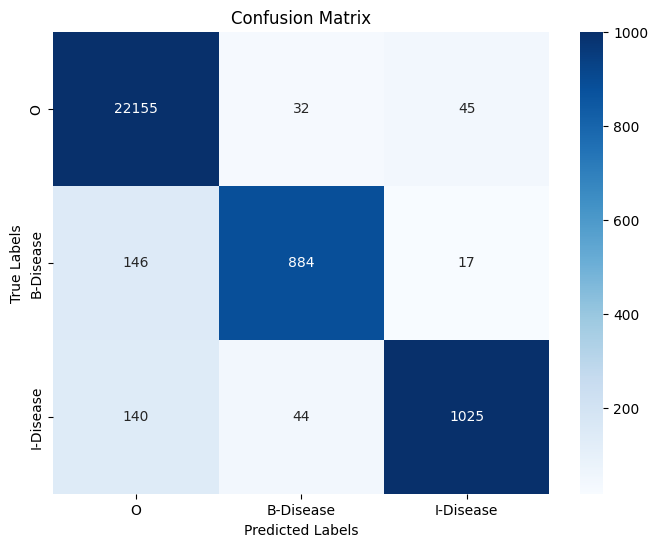

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_list),
            yticklabels=list(label_list),
            vmax=1000)  # Cap color intensity at 1000

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig(f"./CM/NCBI_{batch_size}_test.png", dpi=300, bbox_inches='tight')
plt.show()